# VR - Motion recognition with simple gestures

## Libraries
* Numpy
* Pandas
* Matplotlib
* PyTorch

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.onnx


## Importing scripts

In [2]:
from utils.data import Data
from utils.hardware import Hardware
from utils.model import VRGestureRecognizer

## Loading data

In [3]:
# Define base data directory
base_dir: str = os.path.join(os.getcwd(), 'data')

# Load data
tuple_data: tuple[np.ndarray, np.ndarray, np.ndarray] = Data.load_data(base_dir)

# Unpack data
data: np.ndarray = tuple_data[0]
labels: np.ndarray = tuple_data[1]
classes: np.ndarray = tuple_data[2]

## Settings and hyperparameters ...

In [4]:
DEVICE = Hardware.device()
BATCH_SIZE = 10
EPOCHS = 50

## Model - Convolutional Neural Network

### Training

Epoch [1/50] | Loss: 1.40 | Accuracy: 0.30
Epoch [2/50] | Loss: 1.27 | Accuracy: 0.34
Epoch [3/50] | Loss: 1.28 | Accuracy: 0.46
Epoch [4/50] | Loss: 1.09 | Accuracy: 0.52
Epoch [5/50] | Loss: 1.17 | Accuracy: 0.54
Epoch [6/50] | Loss: 1.44 | Accuracy: 0.54
Epoch [7/50] | Loss: 1.23 | Accuracy: 0.54
Epoch [8/50] | Loss: 1.03 | Accuracy: 0.54
Epoch [9/50] | Loss: 1.41 | Accuracy: 0.54
Epoch [10/50] | Loss: 1.22 | Accuracy: 0.54
Epoch [11/50] | Loss: 1.03 | Accuracy: 0.54
Epoch [12/50] | Loss: 1.31 | Accuracy: 0.54
Epoch [13/50] | Loss: 1.22 | Accuracy: 0.54
Epoch [14/50] | Loss: 1.31 | Accuracy: 0.54
Epoch [15/50] | Loss: 1.21 | Accuracy: 0.54
Epoch [16/50] | Loss: 1.30 | Accuracy: 0.54
Epoch [17/50] | Loss: 1.11 | Accuracy: 0.54
Epoch [18/50] | Loss: 1.14 | Accuracy: 0.54
Epoch [19/50] | Loss: 1.17 | Accuracy: 0.74
Epoch [20/50] | Loss: 0.87 | Accuracy: 0.72
Epoch [21/50] | Loss: 0.96 | Accuracy: 0.76
Epoch [22/50] | Loss: 1.05 | Accuracy: 0.80
Epoch [23/50] | Loss: 0.93 | Accuracy: 0.

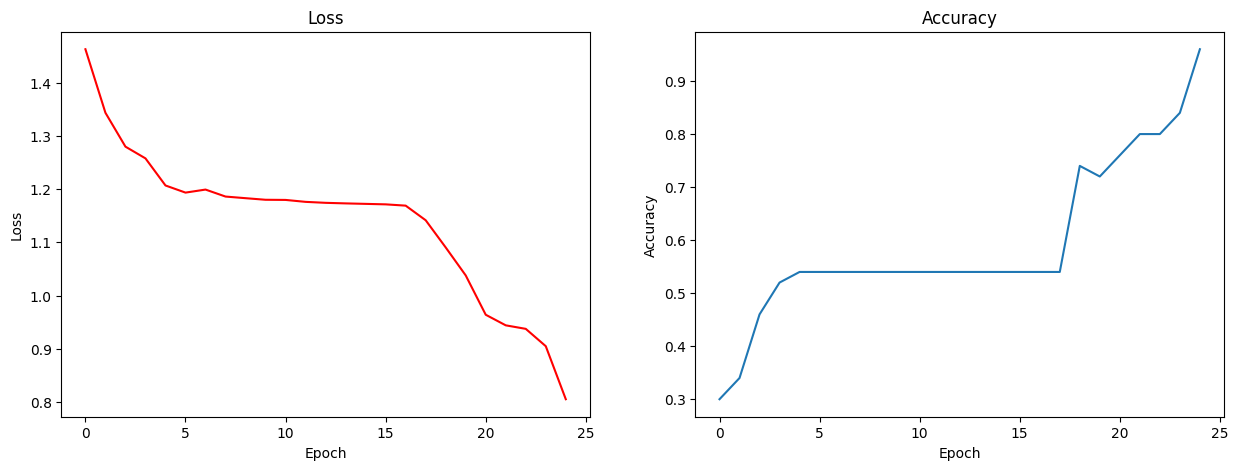

In [5]:
gesture_recognizer = VRGestureRecognizer(hidden_size=128, num_classes=classes.shape[0]).to(Hardware.device(), dtype=torch.float32)
optimizer = torch.optim.Adam(gesture_recognizer.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.15, random_state=42)

gesture_recognizer.compile(optimizer, loss_fn)
training_history = gesture_recognizer.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, learning_rate=1e-4)

def plot_history(history: pd.DataFrame) -> None:
    """
    Plot the training history. The history must be a dataframe with the following columns:
        - Loss
        - Accuracy
    Params:
        history (pd.DataFrame): Training history
    """
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(history['Loss'], color='red')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(history['Accuracy'])
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')

    plt.show()

plot_history(history=training_history)

### Evaluation

In [6]:
test_loss, test_accuracy = gesture_recognizer.evaluate(X_test, y_test)
print(f"Loss: {test_loss.item():.2f} | Accuracy: {test_accuracy * 100:.2f}%")

Loss: 0.79 | Accuracy: 100.00%


## Exporting the model

In [9]:
def export_to_onnx(model: VRGestureRecognizer, path: str) -> None:
    """
    Export the a model instance - with all the weights and biases - to ONNX format.
    This generated file can be used to run inference on a device or environment that does not support PyTorch,
    such as a mobile device or a Virtual Reality headset.
    Params:
        model (VRGestureRecognizer): Model instance
        path (str): Path to the ONNX file
    """
    model.eval()
    X = torch.randn(1, 1, 71, 114, requires_grad=True)
    torch.onnx.export(model.to('cpu'), X, path, export_params=True, opset_version=10, do_constant_folding=True, input_names=['input'], output_names=['output'], dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})

export_to_onnx(gesture_recognizer, 'gesture_recognizer.onnx')

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

